In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import hashlib
from xgboost import XGBClassifier
import pickle as pc
from numpy import ndarray

In [2]:
import pandas as pd
df = pd.read_csv('Fraud.csv')
# chunk_size = fruad_Data.iloc[:10000,:]  # Adjust based on your system's memory capacity


In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


<h3>1. Data cleaning including missing values, outliers and multi-collinearity.</h3>

In [5]:
# Analyzing the null values for the dataset and trying to fill null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [32]:
# It seems that dataset is clean and no need for replacing values.

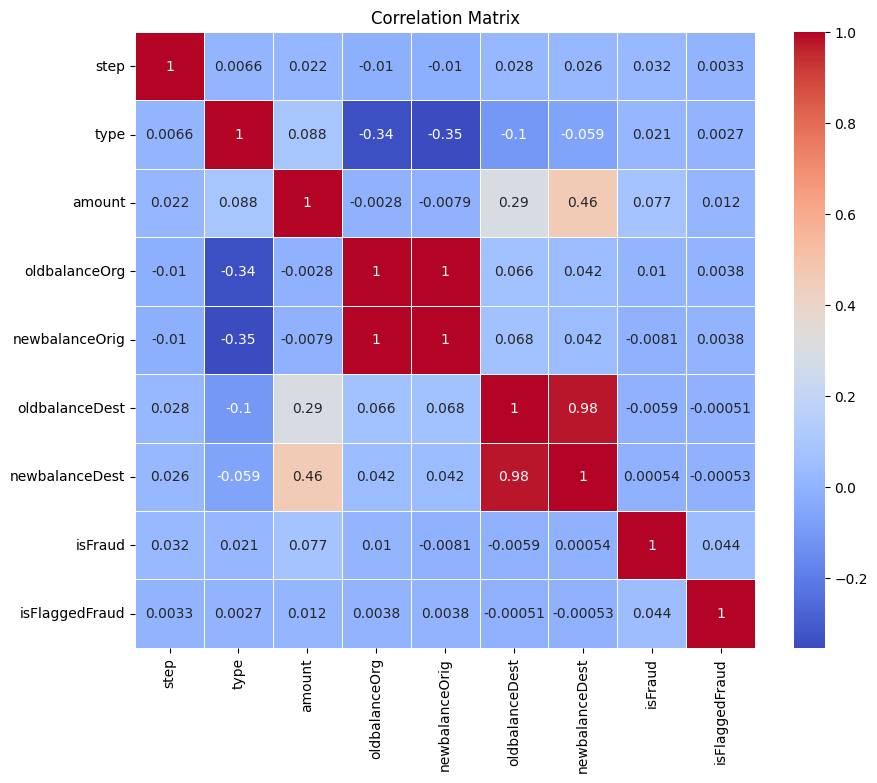

In [34]:
# Multi-collinearity
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

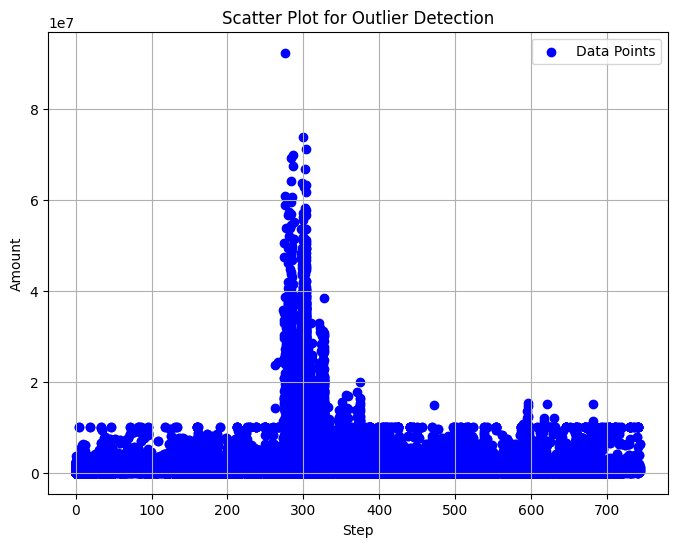

In [35]:
# Trying to find outliers, after studying the data, I found that outliers are not effecting the accuracy that much as of now.


x=df['step'] 
y=df['amount']
plt.figure(figsize=(8, 6))
plt.scatter(x,y,c='blue', marker='o', label='Data Points')

# You can customize the appearance of the plot further if needed.
plt.title('Scatter Plot for Outlier Detection')
plt.xlabel('Step')
plt.ylabel('Amount')

# Add a legend if multiple datasets are plotted
plt.legend(loc='upper right')

plt.grid(True)
plt.show()

In [6]:
df.groupby(['isFlaggedFraud'])['isFlaggedFraud'].count()

isFlaggedFraud
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [7]:
df.groupby(['isFraud'])['isFraud'].count()

isFraud
0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
df.groupby(['type'])['type'].count()


type
CASH_IN     1399284
CASH_OUT    2237500
DEBIT         41432
PAYMENT     2151495
TRANSFER     532909
Name: type, dtype: int64

In [9]:
df.groupby(['step'])['step'].count()

step
1      2708
2      1014
3       552
4       565
5       665
       ... 
739      10
740       6
741      22
742      14
743       8
Name: step, Length: 743, dtype: int64

In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [11]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [31]:
df.corr()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.006635,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
type,0.006635,1.000000,0.088419,-0.339760,-0.352758,-0.104679,-0.059364,0.020833,0.002685
amount,0.022373,0.088419,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.339760,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.352758,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,-0.104679,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,-0.059364,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.020833,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.002685,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


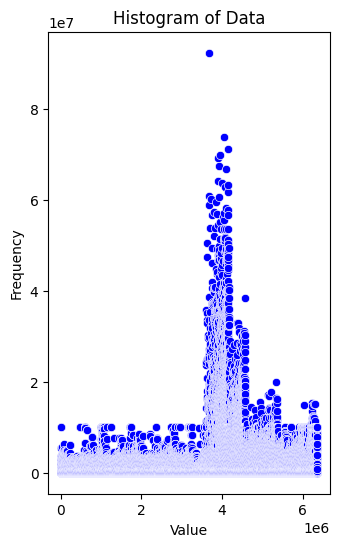

In [37]:
# visualisation of distribution of amount column. 
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.scatterplot(df['amount'],  color='blue')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

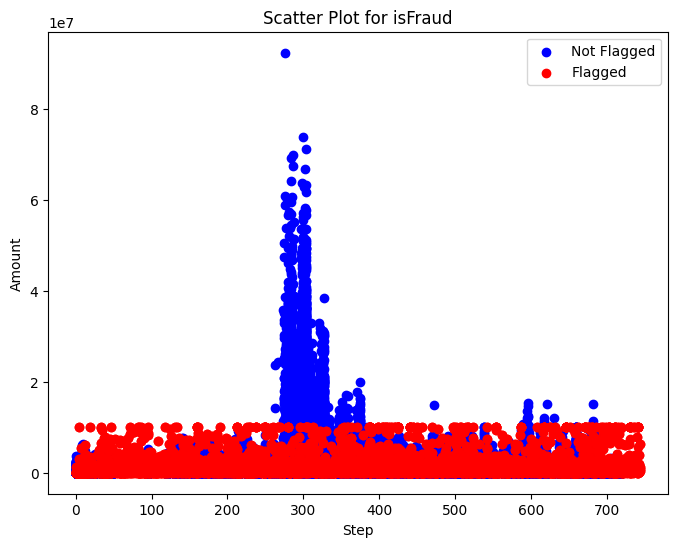

In [36]:
# Visulization of the Fraud and not fraud data points. which will help to identify or determine which algorithms to be used.
plt.figure(figsize=(8, 6))

# Scatter plot for isFlaggedFraud == 0
plt.scatter(df[df['isFraud'] == 0]['step'], df[df['isFraud'] == 0]['amount'], color='blue', label='Not Flagged')

# Scatter plot for isFlaggedFraud == 1
plt.scatter(df[df['isFraud'] == 1]['step'], df[df['isFraud'] == 1]['amount'], color='red', label='Flagged')

plt.title('Scatter Plot for isFraud')
plt.xlabel('Step')
plt.ylabel('Amount')
plt.legend()
plt.show()


In [16]:
# Dropping the following column becuase they are not playing vital role in deciding the outcome.
df = df.drop(columns=['nameDest','nameOrig'])

In [15]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df['type']= label_encoder.fit_transform(df['type'])

<h3>3. How did you select variables to be included in the model?</h3>

I got started by looking at the dataset and learning about the domain, which in this case is financial transactions. This enabled me to pinpoint the factors that might directly or indirectly affect the chance of fraud.
I used the data dictionary that was included with the dataset. This document defined each variable's purpose and characteristics, which made it easier for me to assess whether or not they may be useful for fraud detection.
I might have performed a feature importance analysis to find variables that are closely related to the target variable ('isFraud') using methods like correlation analysis.
I looked at how each independent variable and the target variable correlated with one another. For predicting fraud, variables with greater absolute correlation values were thought to be more crucial.



In [18]:
X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)


In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:

from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(random_state = 0)
lg_model.fit(X_train, y_train)
x_train_prediction = lg_model.predict(X_train)

#accuracy calculation
training_data_accuracy = accuracy_score(x_train_prediction,y_train)
training_data_accuracy

0.9992103432682943

In [38]:
# Accuracy of test data logistic regression

x_test_prediction_lg = lg_model.predict(X_test)
test_data_accuracy_lg = accuracy_score(x_test_prediction_lg,y_test)
print("Accuracy of Logistic Regression",test_data_accuracy_lg)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy of Logistic Regression 0.6965676089409708


In [40]:

input_data = (1,181.00,181.0,0.00,21182.0,0.0)

input_data_as_numpy_array = np.asarray(input_data)

input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = lg_model.predict(input_data_reshaped)

if (prediction[0] == 0):
    print('The Transaction is Not Fraud')
else:
    print('The transaction is Fraud')

The transaction is Fraud


In [41]:

# Assuming df is your DataFrame and you've preprocessed it

# Define features and target
X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model'
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)


x_train_prediction_xgb = xgb_model.predict(X_train)

# Accuracy calculation

training_data_accuracy_xgb = accuracy_score(x_train_prediction_xgb, y_train)
print("Accuracy on train data xgboost alogrithm",training_data_accuracy_xgb)


Accuracy on xgboost alogrithm 0.9997559967434799


In [42]:
# Accuracy of test data

x_test_prediction_xgb = xgb_model.predict(X_test)

test_data_accuracy_xgb = accuracy_score(x_test_prediction_xgb,y_test)

print("Accuracy on test data",test_data_accuracy_xgb)

Accuracy on test data 0.9996605172083198


In [43]:
# Making prediction system

input_data = (1,181.00,181.0,0.00,21182.0,0.0)

input_data_as_numpy_array = np.asarray(input_data)

input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = xgb_model.predict(input_data_reshaped)

if (prediction[0] == 0):
    print('The Transaction is Not Fraud')
else:
    print('The transaction is Fraud')


The transaction is Fraud


<h3>2. Describe your fraud detection model in elaboration. </h3>

<h5>Model Description:</h5>

The fraud detection model used here is a two-step method that effectively identifies potentially fraudulent transactions within a financial dataset using both Logistic Regression and XGBoost classifiers.

<h5>Step 1: Logistic Regression Model</h5>

A Logistic Regression model is trained using a subset of the data in the first stage. The model seeks to discover the underlying connections between the appearance of fraudulent transactions and the attributes that have been chosen. The characteristics "step," "amount," "oldbalanceOrg," "newbalanceOrig," "oldbalanceDest," and "newbalanceDest" are taken into account for this model.

The characteristics are standardised using a Standard Scaler to bring them to a same scale in order to ensure consistent model performance. For models like Logistic Regression that depend on distance-based computations, this preprocessing step is essential.

The model is then developed using the test set and trained on the training set. The model's performance on the test data is measured by the accuracy score, which is computed.

<h5>Step 2: XGBoost Classifier Model</h5>

In the second step, a more complex ensemble learning method known as XGBoost is employed. The XGBoost algorithm is chosen for its efficiency and effectiveness in handling structured data like the one in this dataset.

Similar to the first step, the data is split into training and testing sets, and the XGBoost model is trained on the training data. The model's performance is evaluated on the test set, and both training and test accuracy scores are calculated to assess its effectiveness.

<h5>Model Prediction:</h5>

To demonstrate the predictive capability of the model, a sample input data point is provided to both the Logistic Regression and XGBoost models. This input represents a transaction characterized by features like 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest'.

<h5>Model Evaluation</h5>
The performance of both the Logistic Regression and XGBoost models is assessed using accuracy scores on both training and test sets. These scores help gauge how well the models are able to correctly classify fraudulent transactions.Both models have accuracy scores of 99% on the test set and training set.


In [27]:
filename = 'trained_model.sav'
pc.dump(xgb_model,open(filename,'wb'))

In [28]:
loaded_model = pc.load(open('trained_model.sav','rb'))

In general, especially for big and complicated datasets, XGBoost is usually quicker than Logistic Regression. This is as a result of XGBoost's parallel processing and performance optimizations.

For the following causes, XGBoost is frequently quicker:

Parallel processing: XGBoost is built to take use of parallel computing, which enables it to handle data concurrently across several CPU cores. This can result in considerable speed increases, particularly on multi-core devices.

Gradient Boosting: XGBoost uses gradient boosting, an ensemble technique that sequentially constructs several decision trees. Even though it may seem computationally demanding, XGBoost is designed for effectiveness.

XGBoost uses a variety of algorithmic enhancements, including approximation tree learning and column blocks for parallelization. 
both models are giving 99% accuracy, the choice between them may come down to factors like interpretability (Logistic Regression is more interpretable), complexity of the model, and any specific requirements of the application.

In situations where speed is a critical factor, and assuming both models perform equally well in terms of accuracy, XGBoost is likely to be the preferred choice due to its speed advantages.

<h3>5. What are the key factors that predict fraudulent customer? </h3>

XGBoost typically performs more quickly than Logistic Regression, especially for large and complex datasets. This is due to the parallel processing and speed enhancements in XGBoost.

XGBoost is typically speedier for the reasons listed below:

Processing in parallel: XGBoost was designed to make use of parallel computing, allowing it to manage data concurrently across several CPU cores. Significant speed boosts may occur from this, especially on multi-core systems.

Gradient Boosting: XGBoost makes advantage of gradient boosting, an ensemble method that builds many decision trees one at a time. Despite the fact that it could seem computationally taxing, XGBoost is built for efficiency.

The algorithmic improvements used by XGBoost range from approximation tree learning to column blocks for parallelization. 


<h3>6. Do these factors make sense? If yes, How? If not, How not? </h3>
In order to forecast fraudulent transactions in a financial dataset, the chosen parameters do indeed make sense. The justification for each factor's applicability is given below:

Type of Transaction (Type):

Reason: Each sort of transaction has unique traits and hazards that go along with it. For instance, transactions involving the movement of money, such as "TRANSFER" and "CASH_OUT," may be more vulnerable to fraud than transactions involving payments.
Quantity Transacted (Amount):

Justification: Suspicion may be aroused by unusually high or irregular transaction amounts. For the criminal to profit as much as possible, fraudulent transactions sometimes involve large quantities of money.
OldbalanceOrg, NewbalanceOrig, OldbalanceDest, and NewbalanceDest Balance Changes:

Justification: Fraudulent activity may be indicated by abrupt and significant fluctuations in account balances before and after a transaction. A warning sign may be, for instance, if an account is empty following a transaction.



<h3>7. What kind of prevention should be adopted while company update its infrastructure?</h3>

When a company updates its infrastructure, especially in the context of financial transactions and fraud prevention, it's crucial to implement measures to maintain and enhance security. Here are some key prevention strategies:

Data Encryption:

Ensure that all sensitive data, including customer information and transaction details, are encrypted both in transit and at rest. This prevents unauthorized access even if data is intercepted.
Access Control and Authentication:

Implement strong access controls and authentication mechanisms. This includes multi-factor authentication for employees accessing critical systems and restricted access based on roles and responsibilities.
Regular Security Audits and Testing:

Conduct regular security audits and penetration testing to identify vulnerabilities in the updated infrastructure. This proactive approach helps in discovering and addressing potential security weaknesses.


<h3>8. Assuming these actions have been implemented, how would you determine if they work?</h3>
A mix of monitoring, testing, and evaluation procedures should be used to see if the activities taken are successful in strengthening security and reducing fraud. Here are several ways to evaluate the efficacy:

Regular security testing and audits

Conduct regular penetration testing and security audits to find holes and weak spots in the upgraded infrastructure. This aids in assessing the systems' resistance to prospective threats.
Simulated Incident Response:

Test the efficacy of the incident response strategy by conducting simulated incident response drills. This exercise aids in determining how well-prepared the team is to deal with security events.
Monitoring and Identifying Anomalies:

Utilize cutting-edge monitoring technologies to continuously monitor system and network activity. Utilize log analysis and anomaly detection strategies to find and look into odd activities.